In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

# Load and Clean Data

Data is stored in csv files. A data frame is created with the values:
- Trace - Shortened trace to be used as model input (ex. 1400 points before start of breathold, 100 points after start of breathhold)
- Csv_breath_holds - Breath hold length listed in CSV file
- Data_breath_holds - Breath hold length found using the derivative of the full trace
- Full_trace - Complete breath trace data (given in CSV file)
- breathhold_idx - Indices of the full trace identified as breathhold due to the derivative being zero
- bh_start_end - Indices of the full trace where the breathhold starts and ends (based on breathhold_idx)

In [29]:
beforeBH_len = 1400
afterBH_len = 100
trace_len = beforeBH_len+afterBH_len

In [30]:
# breath_df = get_breath_df('data_sdx_', 1400, 100, True)
# breath_df.to_pickle('breath_pickle')

In [31]:
breath_df = pd.read_pickle('breath_pickle')
breath_df.head(1)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"


In [32]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2 = under2.reset_index(drop=True)
under2.head(1)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"


In [33]:
# Max length 
max_len = max([len(row) for row in under2['Trace']])
trace_len = max_len

In [34]:
trace_lens = [len(row) for row in under2['Trace']]

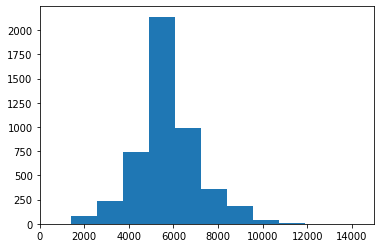

In [35]:
plt.hist(trace_lens, 20)
plt.xlim([0,15000])
plt.show()

In [36]:
print('Average trace len:', np.mean(trace_lens), '\t75th Percentile:', np.percentile(trace_lens, 75), '\tMax trace len:',max_len)

Average trace len: 5751.174911292006 	75th Percentile: 6312.5 	Max trace len: 24720


In [37]:
equalize_len_trace(under2, trace_len)

**Discrepancies:** Only considering files where the breathhold length listed in the CSV files is within 2 seconds of the breathhold length identified using the derivative of the trace to avoid using innacurate breath hold indices.

# Classification 

- **Goal:** Binary classification. "Short" breathholds are in the lower quartile of breath hold lengths and "long" breatholds are in the upper quartile of breath hold lengths.
- **Encoded as:** short (0) and long (1)

In [38]:
q25 = under2['Data_breath_holds'].quantile(.25)
q75 = under2['Data_breath_holds'].quantile(.75)

In [39]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [40]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [41]:
df = under2.reset_index(drop=True)

# Split and Normalize Data

In [47]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.70)

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [50]:
# Change type of each row from np.array to list to put into scaler
x_train = np.array([list(row[::3]) for row in x_train])
x_val = np.array([list(row[::3]) for row in x_val])
x_test = np.array([list(row[::3]) for row in x_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [51]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Initialize Data for Model and Create DataLoader

In [52]:
#dataset
from torch.utils.data import Dataset

In [53]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [54]:
dataset = timeseries(x_train,y_train)
valid_dataset = timeseries(x_val,y_val)
test_dataset = timeseries(x_test,y_test)

In [61]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=100)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=100)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=100)

In [62]:
print("Training Shape", dataset.x.shape, dataset.y.shape)

Training Shape torch.Size([430, 8240]) torch.Size([430])


# Define LSTM Model 

In [63]:
class round_zero_decimals(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        # this can be changed for other decimal places
        n_digits = 0                                     
        exp = torch.pow(10,torch.tensor(n_digits))
        return torch.div( torch.round( input*exp ), exp)
   
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

roundActivation = round_zero_decimals.apply 

In [64]:
class myLSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(myLSTM_Model,self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out_pack, (ht, ct) = self.lstm(x)
        #output = output[:,-1,:] #look at yannet's code
        output = self.linear(ht[-1])
        return output
        

model = myLSTM_Model() 

In [65]:
print(model)

myLSTM_Model(
  (lstm): LSTM(1, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
# Initialize History
history = []

In [78]:
# Declaring Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 30

## Training Loop

In [79]:
trace_len = x_train.shape[1]

In [80]:
for i in range(epochs):
    
    # Training Loss
    train_loss = 0.0
    train_preds = []
    for x, y in train_loader:  
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        roundActivation = round_zero_decimals.apply 
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = F.binary_cross_entropy_with_logits(ypred,y.view(-1,1))   # change loss func
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        train_loss += loss.item()
        train_preds.append(ypred)
    
    # Validation Loss
    valid_loss = 0.0
    val_preds = []
    for x, y in val_loader:
        # Forward Pass
        roundActivation = round_zero_decimals.apply 
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = F.binary_cross_entropy_with_logits(ypred,y.view(-1,1))
        valid_loss += loss.item()
        val_preds.append(ypred)
    
    if i%5 == 0:
        torch.save(model, 'lstm_bh')
        
    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    print(f'Epoch {i+1} \t Training cross entropy loss: {train_loss/len(train_loader)} \tValidation cross entropy loss: {valid_loss/len(val_loader)}')


Epoch 1 	 Training cross entropy loss: 0.6948153734207153 	Validation cross entropy loss: 0.6951608061790466
Epoch 2 	 Training cross entropy loss: 0.6915845513343811 	Validation cross entropy loss: 0.6948676705360413
Epoch 3 	 Training cross entropy loss: 0.6890273451805115 	Validation cross entropy loss: 0.6946074565251669
Epoch 4 	 Training cross entropy loss: 0.6861122608184814 	Validation cross entropy loss: 0.6944049994150797


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'lstm_bh')

## Plot Loss

In [81]:
history = torch.tensor(history)

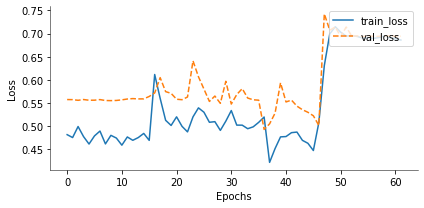

In [82]:
plot_loss(history, maxy = 50)

In [83]:
#test set actual vs predicted
test_set = timeseries(x_test,y_test)
#test_pred = model(test_set[:][0].view(-1,1500,1)).view(-1)

In [ ]:
test_pred = model(test_set[:][0].view(-1,trace_len,1)).view(-1)

In [45]:
testloss = F.binary_cross_entropy_with_logits(test_pred.view(-1,1),test_set.y.view(-1,1))
print("Testing loss: ", testloss.detach().numpy())

Testing loss:  0.67585933
